In [57]:
#Import Statements 
import qiskit as qk
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import Aer
from qiskit.quantum_info import DensityMatrix, state_fidelity, Statevector
from qiskit.circuit.library import UnitaryGate
import numpy as np
import random
from scipy.linalg import eigh


<h1 style="font-family: Arial; color: black;">Procrustean Method for Entanglement Distillation Proof</h1>
<p style="font-family: Times New Roman; font-size: 16px; color: black;">
In this first section of code, we demonstrate two things: the Procrustean distillation technique for strengthening the entanglement between qubits A and B by introducing a qubit A' and applying a unitary gate, and how, once we have the ideal state of entanglement, we can transform these states into a type of Bell state called a singlet for use in the Ekert91 QKD Protocol.
</p>


Fidelity between the singlet state and our distilled state:99.99999999999997%


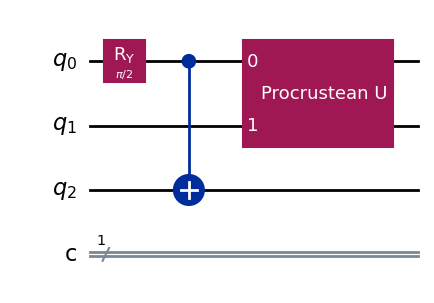

In [78]:
#Create a circuit with three qubits, A, A', B
qc = QuantumCircuit(3, 1)
#This angle lets us control the levels of entanglement between qubits A and B
theta = np.radians(45)
#Applying an ry gate to rotate qubit A and later entagle it with cx
qc.ry(2*theta, 0)
qc.cx(0, 2)

#Defining unitary transformation matrix:
tan_theta = np.tan(theta)
sqrt_term = np.sqrt(1-(tan_theta)**2)

#Define the unitary matrix for application to A and A'
U_matrix = np.array([
    [tan_theta, sqrt_term, 0, 0],
    [0, 0, 1, 0],
    [-sqrt_term, tan_theta, 0, 0],
    [0, 0, 0, 1]
])

U_gate = UnitaryGate(U_matrix, 'Procrustean U')
qc.append(U_gate, [0, 1])

#Density Matrix:
density_matrix = DensityMatrix(qc)
density_matrix_array = np.array(density_matrix)
np.set_printoptions(precision=3, suppress=True)
array = np.array(density_matrix)

np.set_printoptions(precision=3, suppress=True)

#Splitting the density matrix into sub-matrices to apply individual trace operations and obtain a singlet state
A = array[:2, :2]
B = array[:2, 2:4]
C = array[:2, 4:6]
D = array[:2, 6:8]

E = array[2:4, :2]
F = array[2:4, 2:4]
G = array[2:4, 4:6]
H = array[2:4, 6:8]

I = array[4:6, :2]
J = array[4:6, 2:4]
K = array[4:6, 4:6]
L = array[4:6, 6:8]

M = array[6:8, :2]
N = array[6:8, 2:4]
O = array[6:8, 4:6]
P = array[6:8, 6:8]

#Creating a matrix with the trace of sub-matrices A-P
matrix_list = [A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P]
trace_values = [np.trace(matrix) for matrix in matrix_list]
trace_matrix = np.array(trace_values).reshape(4, 4)

#Get the eigenvalues and eigenvectors of the trace matrix
eigenvalues, eigenvectors = eigh(trace_matrix)
max_index = np.argmax(eigenvalues)
psi_AB = eigenvectors[:, max_index]
psi_AB = psi_AB / np.linalg.norm(psi_AB)

#Z and X gate matrices for calculation purposes
Z_gate = np.array([[1, 0], [0, -1]])
X_gate = np.array([[0, 1], [1, 0]])  

#Tensor product of Z and X 
tensor_product = np.kron(Z_gate, X_gate)

#Multiplying the Z and X tensor with the eigenstate corresponding to the maximum eigenvalue of the trace matrix 
resulting_state = np.dot(tensor_product, psi_AB)

#The state of a pure singlet state for fidelity measurement
singlet_state = np.array([0, 1, -1, 0]) / np.sqrt(2)

#Fidelity calculation
overlap = np.abs(np.dot(np.conj(singlet_state), resulting_state))**2
print(f"Fidelity between the singlet state and our distilled state:{overlap*100}%")

#Visualizing the quantum circuit for applying the procrustean
qc.draw('mpl')

In [70]:
#Measuring the state of qubit A'
qc.measure(1, 0)
# print(DensityMatrix(qc))
simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, simulator)
run = simulator.run(transpiled_qc, shots=1024)
result = run.result()

counts = result.get_counts() 
print("States of A':", counts)
#If we measure A' to be 0, we have reached a bell state entanglement between qubit A and B
#An ideal distribution for Procrustean is {'1': 50, '0': 50} for 100 runs distilling 50% of cases.

States of A': {'1': 488, '0': 536}


<p style="font-family: Times New Roman; font-size: 16px; color: black;">
Our Procrustean distillation technique was successful: 26% → 43% → 50%. As the angle (theta) increases, distillation improves, which is expected for Procrustean.
</p>



<h1 style="font-family: Arial; color: black;">Procrustean Distillation for Ekert91 QKD Protocol</h1>
<p style="font-family: Times New Roman; font-size: 16px; color: black;">
In this second section of code, we demonstrate the application of the Procrustean distillation technique to increase the proportion of Bell states (which can be transformed into singlets—typically used in Ekert91 as shown above) among entangled qubits. This strengthens security through improved Bell test violations, better error correction, and enhanced privacy amplification. This technique is particularly advantageous when the optical fiber through which the photons travel is subject to noise and disturbances that degrade the original perfect entanglement.
</p>


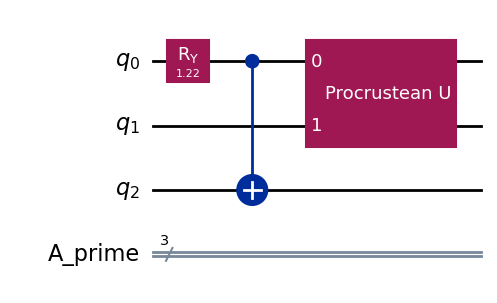

In [71]:
#Ekert91 QKD Protocol
#We use only the successful distillations for Ekert 91 protocol
#Most of this code is similar to the one above
theta_e = np.radians(35)
qreg = QuantumRegister(3, 'q')
creg = ClassicalRegister(3, 'A_prime')
qc_e = QuantumCircuit(qreg, creg, name='og_circuit')

qc_e.ry(2*theta_e, qreg[0])
qc_e.cx(qreg[0], qreg[2])
density_matrix_e = DensityMatrix(qc_e)


tan_theta = np.tan(theta)
sqrt_term = np.sqrt(1-(tan_theta)**2)
U_matrix = np.array([
    [tan_theta, sqrt_term, 0, 0],
    [0, 0, 1, 0],
    [sqrt_term, -tan_theta, 0, 0],
    [0, 0, 0, 1]
])

U_gate = UnitaryGate(U_matrix, 'Procrustean U')
qc_e.append(U_gate, [qreg[0], qreg[1]])

qc_e.draw('mpl')


In [72]:
#After the unitary operation, we measure A'
qc_e.measure(qreg[1], creg[1])
print(qc_e.draw('text'))

           ┌────────────┐     ┌────────────────┐   
      q_0: ┤ Ry(1.2217) ├──■──┤0               ├───
           └────────────┘  │  │  Procrustean U │┌─┐
      q_1: ────────────────┼──┤1               ├┤M├
                         ┌─┴─┐└────────────────┘└╥┘
      q_2: ──────────────┤ X ├───────────────────╫─
                         └───┘                   ║ 
A_prime: 3/══════════════════════════════════════╩═
                                                 1 


In [76]:
#Generalizing Distillations to obtain 500 bell states
#For an angle of 45 degrees. This aligns with the expectation of 50%
simulator = Aer.get_backend('qasm_simulator')

total_runs = 0
success_pairs = 0
singlet_states = []
ideal_counts = {'010': 0.5, '000': 0.5}

updated_result_items = {}
while success_pairs < 500:
    transpiled_ct = transpile(qc_e, simulator)
    run = simulator.run(transpiled_ct, shots=1)
    result = run.result().get_counts()
    total_runs += 1

    for outcome, count in result.items():
        if outcome[-2] == '0':
            success_pairs += 1
            if success_pairs >= 500:
                break

    for key, val in result.items():
        if key in updated_result_items:
            updated_result_items[key] += val
        else:
            updated_result_items[key] = val 

            
    normalized_counts = {k: v / sum(updated_result_items.values()) for k, v in updated_result_items.items()}
    fidelity = sum(np.sqrt(ideal_counts.get(k, 0) * normalized_counts.get(k, 0)) for k in ideal_counts) ** 2

print(f"Total runs: {total_runs}")
print(f"Successful distillation qubits: {success_pairs}")
print(f"Success Rate: {(success_pairs / total_runs) * 100}%")
print(f"Fidelity:{fidelity*100}%")

Total runs: 718
Successful distillation qubits: 500
Success Rate: 69.63788300835655%
Fidelity:95.98210033208686%


<h1 style="font-family: Arial; color: black;">Conclusion</h1>
<p style="font-family: Times New Roman; font-size: 16px; color: black;">
We have demonstrated several important results in this work: (1) the Procrustean distillation technique for entangled qubits using qiskit, (2) a method to convert successfully distilled entangled qubits into singlets for use in the Ekert91 protocol, (3) proof that for a given number of required perfect singlet states, the Procrustean distillation protocol can generate these with high-fidelity states that closely approximate ideal singlets, and (4) the potential to preserve entanglement in practical implementations of Ekert91 quantum key distribution (QKD). 
</p>
<p style="font-family: Times New Roman; font-size: 16px; color: black;">
Thank you!
</p>
